## 10. Recurrent neural networks

step: 0		train err: 0.448023110628		test err: 2.52167320251
step: 100		train err: 0.04733857885		test err: 0.259899437428
step: 200		train err: 0.0421409867704		test err: 0.275590717793
step: 300		train err: 0.0411671847105		test err: 0.337788313627
step: 400		train err: 0.0405542701483		test err: 0.357690632343
Model saved to model.ckpt
('predicted_vals', (22,))


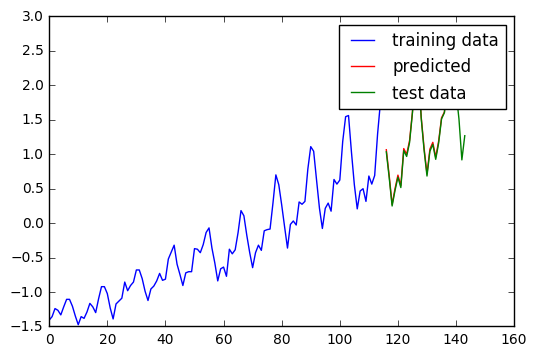

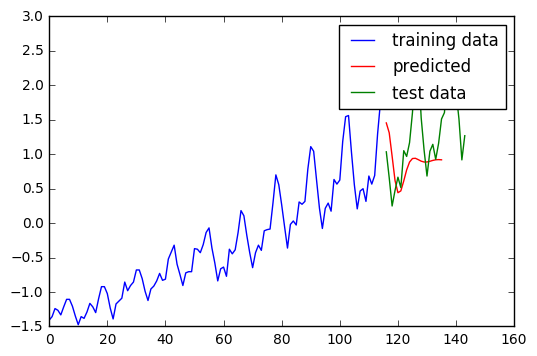

In [13]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
%matplotlib inline

def load_series(filename ,series_dix=1):
    try:
        with open(filename) as csvfile:
            csvreader = csv.reader(csvfile)
            data = [float(row[series_dix]) for row in csvreader if len(row) > 0]
            normalized_data = (data - np.mean(data)) / np.std(data)
        return normalized_data
    except IOError:
        return None

def split_data(data, percent_train=0.80):
    num_rows = len(data)
    train_data, test_data = [], []
    for idx, row in enumerate(data):
        if idx < num_rows * percent_train:
            train_data.append(row)
        else:
            test_data.append(row)
    return train_data, test_data

def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()
class SeriesPredictor:
    
    def __init__(self, input_dim, seq_size, hidden_dim=10):
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        
        self.W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
        self.b_out = tf.Variable(tf.random_normal([1]), name='b_out')
        self.x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
        self.y = tf.placeholder(tf.float32, [None, seq_size])
        self.cost = tf.reduce_mean(tf.square(self.model() - self.y))
        self.train_op = tf.train.AdamOptimizer().minimize(self.cost)
        self.saver = tf.train.Saver()
        
    def model(self):
        with tf.variable_scope("rnn", reuse=True):
            cell = tf.nn.rnn_cell.BasicLSTMCell(self.hidden_dim)
            outputs, states = tf.nn.dynamic_rnn(cell, self.x, dtype=tf.float32)
            
        num_examples = tf.shape(self.x)[0]
        W_repeated = tf.tile(tf.expand_dims(self.W_out, 0), [num_examples, 1, 1])
        out = tf.matmul(outputs, W_repeated) + self.b_out
        out = tf.squeeze(out)
        return out
    
    def train(self, train_x, train_y, test_x, test_y):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            max_patience = 3
            patience = max_patience
            min_test_err = float('inf')
            step = 0
            while patience > 0:
                _, train_err = sess.run([self.train_op, self.cost], feed_dict={self.x: train_x, self.y: train_y})
                if step % 100 == 0:
                    test_err = sess.run(self.cost, feed_dict={self.x: test_x, self.y: test_y})
                    print('step: {}\t\ttrain err: {}\t\ttest err: {}'.format(step, train_err, test_err))
                    if test_err < min_test_err:
                        min_test_err = test_err
                        patience = max_patience
                    else:
                        patience -= 1
                step += 1
            save_path = self.saver.save(sess, "model.ckpt")
            print("Model saved to {}".format(save_path))
        
    def test(self, sess, test_x):
        tf.get_variable_scope().reuse_variables()
        self.saver.restore(sess, "./model.ckpt")
        output = sess.run(self.model(), feed_dict={self.x: test_x})
        return output

seq_size = 5
predictor = SeriesPredictor(input_dim=1, seq_size=seq_size, hidden_dim = 100)

data = load_series('international-airline-passengers.csv')
train_data, actual_vals = split_data(data)
train_x, train_y = [], []
for i in range(len(train_data) - seq_size - 1):
    train_x.append(np.expand_dims(train_data[i:i+seq_size], axis=1).tolist())
    train_y.append(train_data[i+1:i+seq_size+1])
    
test_x, test_y = [], []
for i in range(len(actual_vals) - seq_size - 1):
    test_x.append(np.expand_dims(actual_vals[i:i+seq_size], axis=1).tolist())
    test_y.append(actual_vals[i+1:i+seq_size+1])
    
predictor.train(train_x, train_y, test_x, test_y)

with tf.Session() as sess:
    predicted_vals = predictor.test(sess, test_x)[:,0]
    print('predicted_vals', np.shape(predicted_vals))
    plot_results(train_data, predicted_vals, actual_vals, 'predictions.png')
    prev_seq = train_x[-1]
    predicted_vals = []
    for i in range(20):
        next_seq = predictor.test(sess, [prev_seq])
        predicted_vals.append(next_seq[-1])
        prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))
    plot_results(train_data, predicted_vals, actual_vals, 'hallucinations.png')